In [8]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Read in the trip summary data
# file_path = '../data/trip_summary_201901.csv'
file_path = '../data/trip_summary_201808_201901.csv'
trips = pd.read_csv(file_path)
trips = trips.dropna(how="any")

trips['start_station_id'].nunique()

152

In [3]:
# Create station pair identifiers and sort the data

# Function: sorts the pair array and concatenates them to create a unique ID
def sort_concat(arr):
    arr_sorted = np.sort(arr)
    pair_id = str(arr_sorted[0]) + '_' + str(arr_sorted[1])
    
    return pair_id

pair_id = trips[['start_station_id', 'end_station_id']].values
pair_id_sorted = list(map(sort_concat, pair_id))

trips['station_pair_id'] = pair_id_sorted

trips.head()

,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,end_station_has_kiosk,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,sum_duration_sec,sum_duration_min,trip_count,subscriber_trip_count,customer_trip_count,station_pair_id
0,2018-08-01,0,100,Bryant St at 15th St,19.0,True,122,19th St at Mission St,19.0,True,37.767100,-122.410662,37.760299,-122.418892,325,5.416667,1,1,0,100_122
1,2018-08-01,0,100,Bryant St at 15th St,19.0,True,97,14th St at Mission St,19.0,True,37.767100,-122.410662,37.768265,-122.420110,405,6.750000,1,1,0,97_100
2,2018-08-01,0,110,17th & Folsom Street Park (17th St at Folsom St),23.0,True,133,Valencia St at 22nd St,23.0,True,37.763708,-122.415204,37.755213,-122.420975,466,7.766667,1,1,0,110_133
3,2018-08-01,0,16,Steuart St at Market St,23.0,True,16,Steuart St at Market St,23.0,True,37.794130,-122.394430,37.794130,-122.394430,989,16.483333,1,1,0,16_16
10,2018-08-01,0,343,Bryant St at 2nd St,27.0,True,58,Market St at 10th St,31.0,True,37.783172,-122.393572,37.776619,-122.417385,1132,18.866667,1,1,0,58_343


### Generate an Affinity Matrix from the Data

In [4]:
# Create a new dataframe that sums the roundtrips between two stations into one row of data
# We will be able to create a matrix on how each station interactions with other stations
pair_trips = trips.groupby('station_pair_id', as_index=False)['trip_count','sum_duration_min'].sum()
pair_trips['station_i'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[0]
pair_trips['station_j'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[1]
intercluster_volume = pair_trips
pair_trips['trip_count_inv'] = 1 / pair_trips['trip_count']

pair_trips['station_i'] = pd.to_numeric(pair_trips['station_i']).astype(np.int64)
pair_trips['station_j'] = pd.to_numeric(pair_trips['station_j']).astype(np.int64)

# Sort the dataframe by the starting station, so we can link up the clusters to the correct row of data later on
stations_sorted = pair_trips.sort_values(['station_i'])['station_i'].unique()
pair_trips = pair_trips.sort_values(['station_i'])

# Generate affinity matrix from pair_trips
upp_mat = pair_trips.set_index(['station_i','station_j'])['trip_count_inv'].unstack().values

aff_mat = np.triu(upp_mat) + np.triu(upp_mat, 1).T
aff_mat[np.isnan(aff_mat)] = 0

print(aff_mat, "\n")
print(aff_mat.shape)

[[0.0025     0.00934579 0.0018622  ... 0.1        0.33333333 0.09090909]
 [0.00934579 0.01351351 0.01030928 ... 0.33333333 0.2        0.14285714]
 [0.0018622  0.01030928 0.00265252 ... 0.05263158 0.33333333 0.11111111]
 ...
 [0.1        0.33333333 0.05263158 ... 0.03703704 0.         1.        ]
 [0.33333333 0.2        0.33333333 ... 0.         0.04166667 1.        ]
 [0.09090909 0.14285714 0.11111111 ... 1.         1.         1.        ]] 

(152, 152)


In [32]:
# Spectral clustering on the affinity matrix
from sklearn.cluster import SpectralClustering

beta = 1
sim_mat = np.exp(-beta * aff_mat / aff_mat.std(ddof=0))
#print(sim_mat)

sc = SpectralClustering(10, affinity='precomputed', n_init=100, assign_labels='discretize')
clusters = sc.fit_predict(sim_mat)
#print(len(clusters))

In [31]:
#clusters

In [7]:
# list(zip(stations_sorted, clusters))

### Test performance of spectral clustering on 1-15 clusters

#### Output from this cell shows the mean volume and time for intercluster travel

In [35]:
intercluster_volume.head()

,station_i,station_j,trip_count,sum_duration_min,cluster_i,cluster_j,intercluster_trip,intracluster_trip,intercluster_volume,intercluster_time_volume,intracluster_volume,intracluster_time_volume,intra:inter_volume,intra:inter_time_volume
0,100,100,0.005354,0.003858,10,10,0.0,1.0,0.000000,0.000000,0.005354,0.003858,inf,inf
1,100,101,0.018328,0.003518,10,8,1.0,0.0,0.018328,0.003518,0.000000,0.000000,0.000000,0.000000
2,100,102,0.019357,0.005756,10,5,1.0,0.0,0.019357,0.005756,0.000000,0.000000,0.000000,0.000000
3,100,104,0.008855,0.006286,10,8,1.0,0.0,0.008855,0.006286,0.000000,0.000000,0.000000,0.000000
4,100,105,0.004119,0.002609,10,4,1.0,0.0,0.004119,0.002609,0.000000,0.000000,0.000000,0.000000


In [34]:
# from sklearn.preprocessing import MinMaxScaler

# array = intercluster_volume[['trip_count','sum_duration_min']].values
# scaler = MinMaxScaler()
# array_scaled = scaler.fit_transform(array)
# intercluster_volume_test = intercluster_volume
# intercluster_volume_test[['trip_count','sum_duration_min']] = array_scaled
# intercluster_volume_test.head()

In [71]:
# cluster_dict
df_test = pd.DataFrame.from_dict(cluster_dict, orient='index')
df_test = df_test.reset_index()
df_test.iloc[:,0] = df_test.iloc[:,0].rename("station")
df_test.iloc[:,1] = df_test.iloc[:,1].rename("cluster")
df_test.head()


,index,0
0,3,8
1,4,11
2,5,11
3,6,3
4,8,3


In [44]:
# Spectral clustering on the affinity matrix
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler

print("clusters","  ", "avg inter volume", " ", "avg inter time",
      " ", "avg intra volume", " ", "avg intra time", 
      " ","intra:inter_volume",  " ", "intra:inter_time_volume")

i = 2

scaler = MinMaxScaler(feature_range=(0, 100))

cluster_list = []
avg_inter_vol_list = []
avg_inter_time_list = []
avg_intra_vol_list = []
avg_intra_time_list = []
avg_intra_inter_volume_list = []
avg_intra_inter_time_volume_list = []

while i <= 15:

    sc = SpectralClustering(i, affinity='precomputed', n_init=100, assign_labels='discretize')
    clusters = sc.fit_predict(sim_mat)
    
    # select start station and trip count to new dataframe
    intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]
    
    # normalize trip_count and sum_duration_min so we can compare accross months and/or different time periods
    array = intercluster_volume[['trip_count','sum_duration_min']].values
    array_scaled = scaler.fit_transform(array)
    intercluster_volume[['trip_count','sum_duration_min']] = array_scaled

    #define a mapping dictionary
    cluster_dict = dict(zip(stations_sorted, clusters))

    # map the clusters to the starting stations
    intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
    intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)
    
    #store station cluster labels for each iteration
    

    #intercluster trips
    intercluster_volume.loc[intercluster_volume.cluster_i == intercluster_volume.cluster_j, 'intercluster_trip'] = 0 
    intercluster_volume.loc[intercluster_volume.cluster_i != intercluster_volume.cluster_j, 'intercluster_trip'] = 1
    
    #intracluster trips
    intercluster_volume.loc[intercluster_volume.cluster_i == intercluster_volume.cluster_j, 'intracluster_trip'] = 1 
    intercluster_volume.loc[intercluster_volume.cluster_i != intercluster_volume.cluster_j, 'intracluster_trip'] = 0
    
    #get inter trip volume and duration time
    intercluster_volume['intercluster_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['trip_count']
    intercluster_volume['intercluster_time_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['sum_duration_min']
    
    #get intra trip volume and duration time
    intercluster_volume['intracluster_volume'] = intercluster_volume['intracluster_trip']*intercluster_volume['trip_count']
    intercluster_volume['intracluster_time_volume'] = intercluster_volume['intracluster_trip']*intercluster_volume['sum_duration_min']
    
    #compute intra:inter volume ratio
    intercluster_volume['intra:inter_volume'] = intercluster_volume['intracluster_volume']/intercluster_volume['intercluster_volume']
    
    #compute intra:inter duration ratio
    intercluster_volume['intra:inter_time_volume'] = intercluster_volume['intracluster_time_volume']/intercluster_volume['intercluster_time_volume']

    print(i,
          "            ", round(intercluster_volume['intercluster_volume'].mean(),4),
          "            ", round(intercluster_volume['intercluster_time_volume'].mean(),4),
          "            ", round(intercluster_volume['intracluster_volume'].mean(),4),
          "            ", round(intercluster_volume['intracluster_time_volume'].mean(),4),
          "            ", round(intercluster_volume['intra:inter_volume'].mean(),4),
          "            ", round(intercluster_volume['intra:inter_time_volume'].mean(),4))
    
    #Builds lists to enable plotting
    cluster_list.append(i)
    
    #inter
    avg_inter_vol_list.append(intercluster_volume['intercluster_volume'].mean())
    avg_inter_time_list.append(intercluster_volume['intercluster_time_volume'].mean())
    
    #intra
    avg_intra_vol_list.append(intercluster_volume['intracluster_volume'].mean())
    avg_intra_time_list.append(intercluster_volume['intracluster_time_volume'].mean())
    
    #intra:inter
    avg_intra_inter_volume_list.append(intercluster_volume['intra:inter_volume'].mean())
    avg_intra_inter_time_volume_list.append(intercluster_volume['intra:inter_time_volume'].mean())

    i = i + 1

clusters    avg inter volume   avg inter time   avg intra volume   avg intra time   intra:inter_volume   intra:inter_time_volume
2              0.305              0.3036              1.1197              0.8437              inf              inf
3              0.3903              0.4002              1.0344              0.7472              inf              inf
4              0.588              0.5418              0.8367              0.6056              inf              inf
5              0.5391              0.5009              0.8856              0.6465              inf              inf
6              0.5787              0.5431              0.846              0.6043              inf              inf
7              0.9031              0.7545              0.5215              0.3929              inf              inf
8              1.0198              0.829              0.4049              0.3183              inf              inf
9              1.0008              0.8186              0.4239  

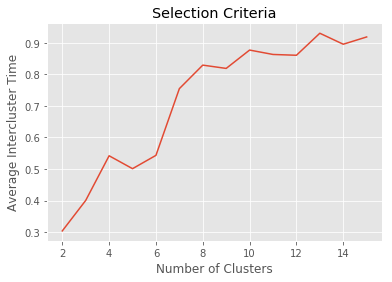

In [45]:
plt.plot(cluster_list,avg_inter_time_list)

plt.xlabel('Number of Clusters')
plt.ylabel('Average Intercluster Time')
plt.title('Selection Criteria')
plt.show()


In [ ]:
intercluster_volume

### Generate a Dataframe that has the pertinent information for Data Visualization

In [12]:
station_clustered = list(zip(stations_sorted, clusters))
df_station_clustered = pd.DataFrame(station_clustered)
df_station_clustered.rename(columns={0:'station_id',
                                    1: 'cluster'},inplace=True)

start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns = {'start_station_id':'station_id', \
                                                 'start_station_name':'station_name', \
                                                 'start_station_latitude':'station_latitude', 
                                                 'start_station_longitude': 'station_longitude'})

end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns = {'end_station_id':'station_id', \
                                             'end_station_name':'station_name', \
                                             'end_station_latitude':'station_latitude', \
                                             'end_station_longitude': 'station_longitude'})

df_loc = pd.concat([start, end]).drop_duplicates()
df_all = df_loc.merge(df_station_clustered, on=["station_id"], how="right")
df_all.to_csv("clusters_spectral_clustering.csv", index=None)
df_all.head()

,station_id,station_name,station_latitude,station_longitude,cluster
0,109,17th St at Valencia St,37.763316,-122.421904,0
1,118,Eureka Valley Recreation Center,37.759177,-122.436943,2
2,119,18th St at Noe St,37.761047,-122.432642,0
3,120,Mission Dolores Park,37.761420,-122.426435,0
4,121,Mission Playground,37.759210,-122.421339,0
5,13,Commercial St at Montgomery St,37.794231,-122.402923,3
6,138,Jersey St at Church St,37.750900,-122.427411,7
7,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,4
8,16,Steuart St at Market St,37.794130,-122.394430,4
9,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,6


### Extra Code for single run of volume and time volume aggregation

In [73]:
# map clusters to roundtrip volume and rountrip volume time data

# select start station and trip count to new dataframe
intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]

#define a mapping dictionary
cluster_dict = dict(zip(stations_sorted, clusters))

# map the clusters to the starting stations
intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)


intercluster_volume.loc[intercluster_volume.cluster_i == intercluster_volume.cluster_j, 'intercluster_trip'] = 0 
intercluster_volume.loc[intercluster_volume.cluster_i != intercluster_volume.cluster_j, 'intercluster_trip'] = 1 

intercluster_volume['intercluster_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['trip_count']
intercluster_volume['intercluster_time_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['sum_duration_min']

intercluster_volume.head()

,station_i,station_j,trip_count,sum_duration_min,cluster_i,cluster_j,intercluster_trip,intercluster_volume,intercluster_time_volume
0,100,100,8,72.833333,8,8,0.0,0.0,0.000000
1,100,101,7,18.816667,8,3,1.0,7.0,18.816667
2,100,102,9,40.783333,8,5,1.0,9.0,40.783333
3,100,104,11,106.333333,8,4,1.0,11.0,106.333333
4,100,105,6,54.516667,8,0,1.0,6.0,54.516667
